In [173]:
import pandas as pd

# โหลดข้อมูล CSV
file_path = r"E:\uuuuuuuuuuuuuuuuuuu\data\sensor_data_1000.csv"
df = pd.read_csv(file_path)

In [174]:
# แสดงตัวอย่างข้อมูล 5 แถวแรก
print(df.head())

   Temperature  Vibration  Machine_Age  Humidity     RPM  Operating_Hours  \
0        76.22      0.359          2.6     60.36  2058.4           3997.0   
1       116.55      0.859          2.5     67.80  2572.0           4787.0   
2       101.24      1.322          9.1     35.03  2472.4           8560.0   
3        91.91      1.125          2.5     57.49  1138.6           3466.0   
4        60.92      1.229          2.7     54.30  1128.3           8709.5   

   Maintenance_Required  
0                     0  
1                     0  
2                     1  
3                     0  
4                     0  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# มี DataFrame df อยู่แล้ว
def label_abnormality(row):
    labels = []
    if row['Temperature'] > 100:
        labels.append("High Temperature")
    if row['Vibration'] > 1.0:
        labels.append("High Vibration")
    if row['Machine_Age'] > 7 or row['Operating_Hours'] > 5000:
        labels.append("Aging/High Usage")
    # กำหนด label ตามจำนวน abnormality ที่พบ
    if len(labels) == 0:
        return "Normal"
    elif len(labels) == 1:
        return labels[0]
    else:
        return "Multiple Abnormalities"

# สร้าง Label ใหม่
df['Abnormality_Type'] = df.apply(label_abnormality, axis=1)

# เปลี่ยน Label ให้เป็นตัวเลข (Encoding)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Abnormality_Label'] = le.fit_transform(df['Abnormality_Type'])


In [176]:
# ตรวจสอบข้อมูลเบื้องต้น
print(df.info())  # ดูประเภทของข้อมูล และค่าที่หายไป
print(df.describe())  # ดูค่าสถิติ เช่น ค่าเฉลี่ย ค่าสูงสุด ค่าต่ำสุด

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           1000 non-null   float64
 1   Vibration             1000 non-null   float64
 2   Machine_Age           1000 non-null   float64
 3   Humidity              1000 non-null   float64
 4   RPM                   1000 non-null   float64
 5   Operating_Hours       1000 non-null   float64
 6   Maintenance_Required  1000 non-null   int64  
 7   Abnormality_Type      1000 non-null   object 
 8   Abnormality_Label     1000 non-null   int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 70.4+ KB
None
       Temperature    Vibration  Machine_Age     Humidity          RPM  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     84.317880     0.809811     5.023300    49.422520  1887.029700   
std      20.449611     0.409064     2.906619

ค่า count ต้องเท่ากับ 1000 (แสดงว่าไม่มี Missing Values)
✔ ดู min และ max ว่าค่าผิดปกติไหม (เช่น RPM ต่ำเกินไปไหม?)
✔ std (Standard Deviation) สูงมาก อาจหมายถึงข้อมูลกระจายตัวสูง

In [177]:
# แสดงจำนวน Missing Values ในแต่ละคอลัมน์
print(df.isnull().sum())


Temperature             0
Vibration               0
Machine_Age             0
Humidity                0
RPM                     0
Operating_Hours         0
Maintenance_Required    0
Abnormality_Type        0
Abnormality_Label       0
dtype: int64


✔ ไม่มี Missing Values (ค่า NaN)

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns

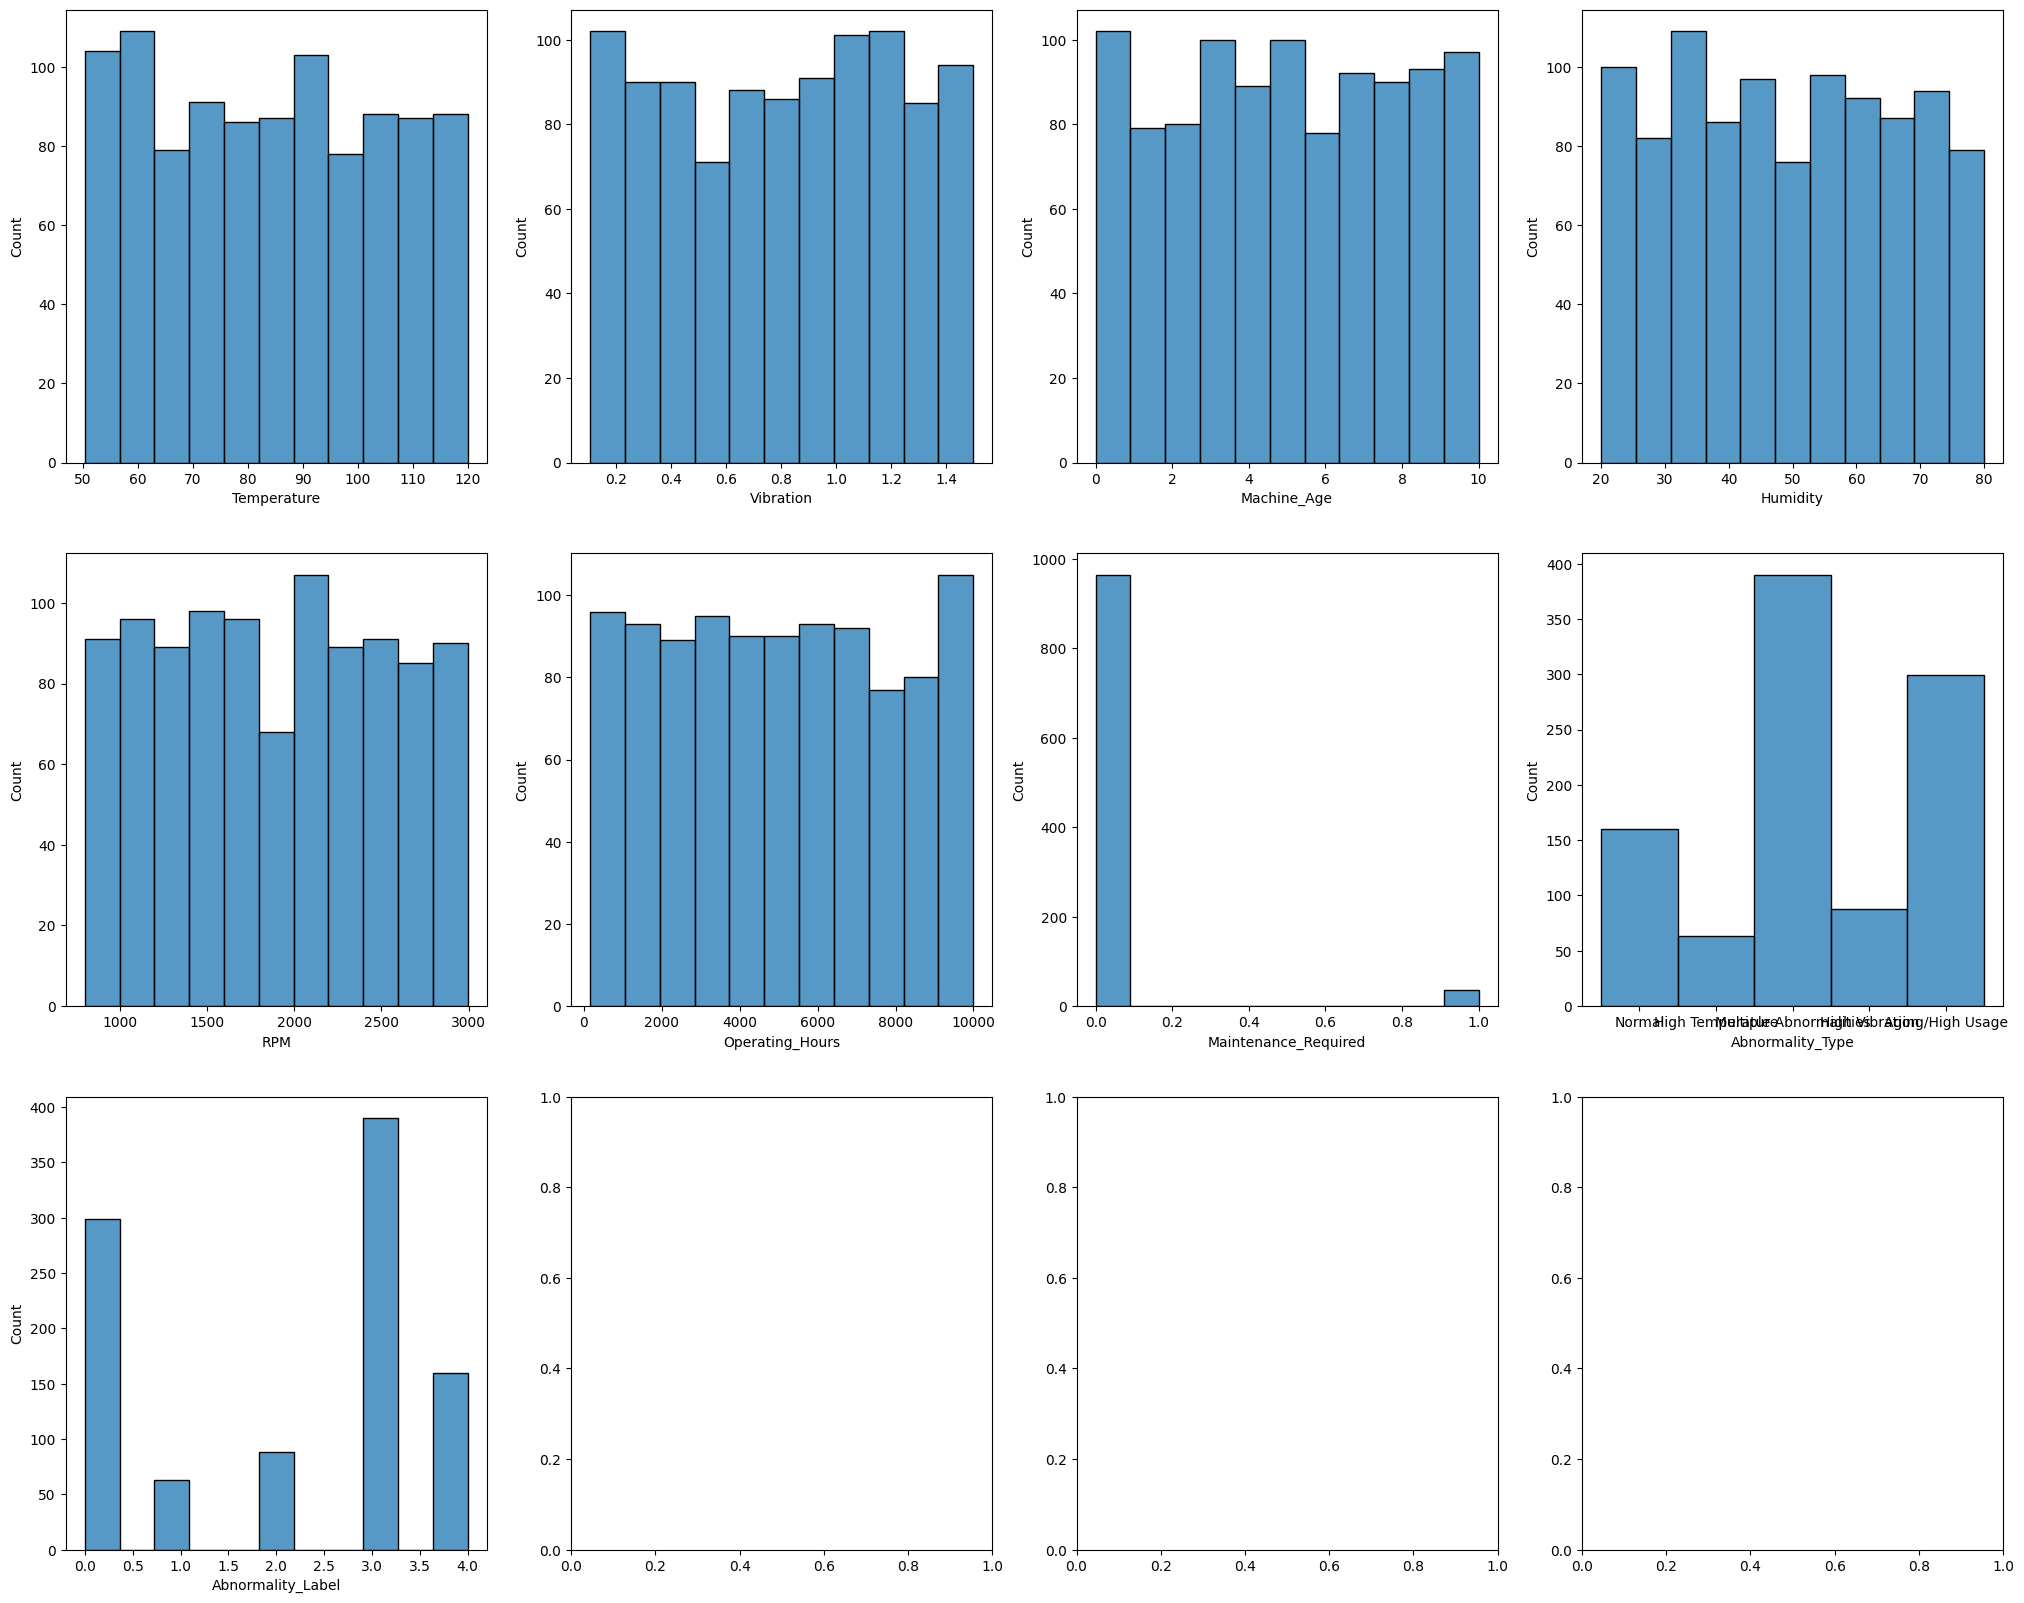

In [179]:
fig, ax = plt.subplots(3, 4, figsize=(25, 20))

for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=ax[i//4][i%4])

In [181]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df.copy()  # สำรองข้อมูลก่อน
df_scaled[["Temperature", "Vibration", "Machine_Age", "Humidity", "RPM", "Operating_Hours", "Abnormality_Label"]] = scaler.fit_transform(
    df[["Temperature", "Vibration", "Machine_Age", "Humidity", "RPM", "Operating_Hours", "Abnormality_Label"]]
)

In [182]:
import pandas as pd

# ฟังก์ชันสำหรับลบ outliers ด้วย IQR method
def remove_outliers_iqr(dataframe, columns):
    Q1 = dataframe[columns].quantile(0.25)
    Q3 = dataframe[columns].quantile(0.75)
    IQR = Q3 - Q1

    # กำหนดขอบเขตสำหรับค่าปกติ
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # กรองเฉพาะค่าที่อยู่ในช่วงปกติ
    filtered_df = dataframe[
        ~((dataframe[columns] < lower_bound) | (dataframe[columns] > upper_bound)).any(axis=1)
    ]
    
    return filtered_df


# เลือกเฉพาะคอลัมน์ตัวเลขที่ต้องการกรอง outliers
num_columns = ["Temperature", "Vibration", "Machine_Age", "Humidity", "RPM", "Operating_Hours"]
df_cleaned = remove_outliers_iqr(df, num_columns)

# แสดงขนาดข้อมูลก่อนและหลังการลบ outliers
print("Before:", df.shape)
print("After:", df_cleaned.shape)


Before: (1000, 9)
After: (1000, 9)


In [183]:
# แบ่งข้อมูล
X = df.drop(columns=['Maintenance_Required', 'Abnormality_Type', 'Abnormality_Label'])
y = df['Abnormality_Label']

In [185]:
from imblearn.over_sampling import SMOTE

X = df.drop(columns=['Maintenance_Required', 'Abnormality_Type', 'Abnormality_Label'])
y = df['Abnormality_Label']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [186]:
from sklearn.model_selection import train_test_split

# แบ่งข้อมูลเป็น 80% Training, 20% Testing
X = df.drop(columns=['Maintenance_Required', 'Abnormality_Type', 'Abnormality_Label'])  # ตัวแปรที่ใช้ทำนาย
y = df['Abnormality_Label']  # ตัวแปรเป้าหมาย

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [187]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# สร้างโมเดล Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# ฝึกสอนโมเดล
model.fit(X_train, y_train)

# ทำนายผล
y_pred = model.predict(X_test)

# ประเมินผล
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        72
           4       1.00      1.00      1.00        38

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Confusion Matrix:
[[58  0  0  0  0]
 [ 0 16  0  0  0]
 [ 0  0 16  0  0]
 [ 0  0  0 72  0]
 [ 0  0  0  0 38]]


In [188]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5)
print("Cross-Validation Accuracy: ", scores.mean())


Cross-Validation Accuracy:  0.998


In [189]:
importances = model.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")


Temperature: 0.2474
Vibration: 0.3255
Machine_Age: 0.1394
Humidity: 0.0291
RPM: 0.0315
Operating_Hours: 0.2271


In [195]:
import joblib

# บันทึกโมเดล RandomForest ที่ฝึกแล้ว
joblib.dump(model, "machine_failure_model.pkl")

# บันทึก LabelEncoder ที่ใช้กับ Abnormality_Type
joblib.dump(le, "label_encoder.pkl")

print("บันทึกโมเดลสำเร็จ ✅")


บันทึกโมเดลสำเร็จ ✅
